<a href="https://colab.research.google.com/github/DFazekas/thesis_analysis/blob/main/Thesis_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data
First, important the data and ensure all columns have equal non-null rows.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Demand         270 non-null    object 
 1   Penetration    270 non-null    object 
 2   Travel Time    270 non-null    int64  
 3   Run            270 non-null    int64  
 4   Waiting Time   270 non-null    int64  
 5   Time Loss      270 non-null    float64
 6   Waiting Count  270 non-null    int64  
 7   Average Speed  270 non-null    float64
 8   Crossing       270 non-null    int64  
 9   Following      270 non-null    int64  
 10  Merging        270 non-null    int64  
 11  RTT            270 non-null    int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 25.4+ KB


# Safety Analysis
This section focuses on the conflict types experienced by the emergency vehicle.

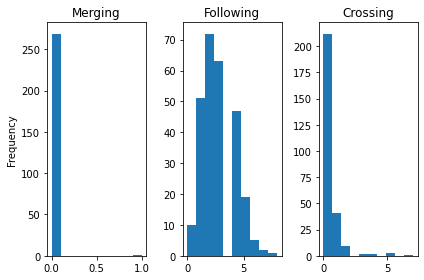

In [4]:
fig = plt.subplot(1,3,1)

# Merging
plt.ylabel("Frequency")
plt.title("Merging")
plt.hist(df['Merging'])

# Following
plt.subplot(1,3,2)
plt.title("Following")
plt.hist(df['Following'])

# Crossing
plt.subplot(1,3,3)
plt.title("Crossing")
plt.hist(df['Crossing'])

plt.tight_layout()

In [5]:
print(f"Merging: {df['Merging'].sum()}")
print(f"Following: {df['Following'].sum()}")
print(f"Crossing: {df['Crossing'].sum()}")

Merging: 1
Following: 719
Crossing: 95


We observe that there were almost no merging conflicts, while 95 crossing conflicts and 719 following conflicts were observed. Therefore, further analysis will focus only on crossing and following conflicts.

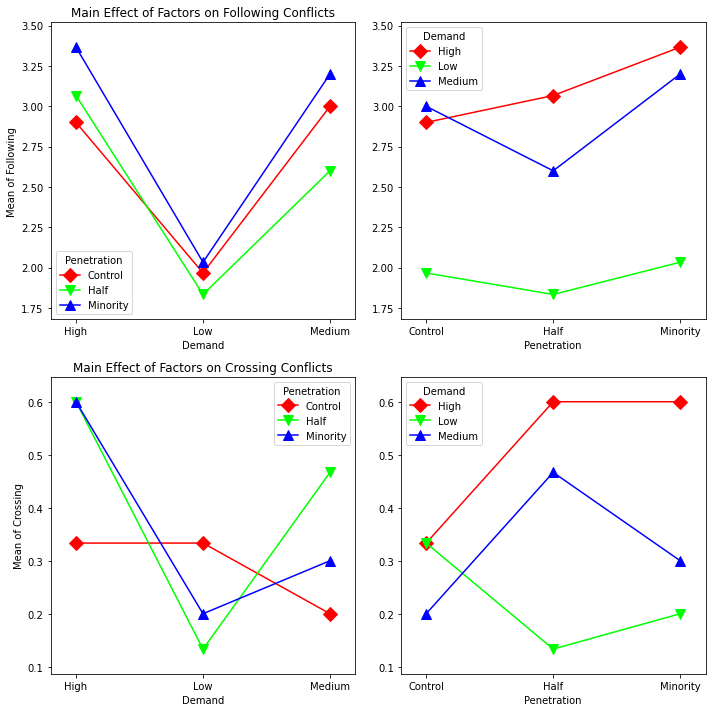

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))


# Following
fig = interaction_plot(df['Demand'], df['Penetration'], df['Following'], ms=10, ax=axs[0,0], markers=['D',"v",'^'])
axs[0,0].set_title("Main Effect of Factors on Following Conflicts")
axs[0,0].set_ylabel("Mean of Following")

fig = interaction_plot(df['Penetration'], df['Demand'], df['Following'], ms=10, ax=axs[0,1], markers=['D',"v",'^'])
axs[0,1].set_ylabel("")

# Crossing
fig = interaction_plot(df['Demand'], df['Penetration'], df['Crossing'], ms=10, ax=axs[1,0], markers=['D',"v",'^'])
axs[1,0].set_title("Main Effect of Factors on Crossing Conflicts")
axs[1,0].set_ylabel("Mean of Crossing")

fig = interaction_plot(df['Penetration'], df['Demand'], df['Crossing'], ms=10, ax=axs[1,1], markers=['D',"v",'^'])
axs[1,1].set_ylabel("")

plt.tight_layout()

## ANOVA tests on safety responses 

In [7]:
model_following = ols('Following ~ Demand + Penetration + Demand*Penetration', data=df).fit()
sm.stats.anova_lm(model_following, typ=2)

,sum_sq,df,F,PR(>F)
Demand,71.118519,2.0,19.350129,1.458538e-08
Penetration,6.274074,2.0,1.707068,1.834159e-01
Demand:Penetration,3.303704,4.0,0.449441,7.727666e-01
Residual,479.633333,261.0,NaN,NaN


In [8]:
model_crossing = ols('Crossing ~ Demand + Penetration + Demand*Penetration', data=df).fit()
sm.stats.anova_lm(model_crossing, typ=2)

,sum_sq,df,F,PR(>F)
Demand,3.874074,2.0,2.400981,0.092628
Penetration,0.585185,2.0,0.362672,0.696165
Demand:Penetration,2.548148,4.0,0.789615,0.532800
Residual,210.566667,261.0,NaN,NaN


# Analysis of RTT
This section focuses on the analysis and modeling of the RTT (reduced travel time) response variable.

## Testing ANOVA Assumptions
Before we perform a Brown-Forsythe test, we can calculate the variance of the plant measurements in each group.

In [17]:
group_control = df[df['Penetration'] == 'Control']['RTT']
group_minority = df[df['Penetration'] == 'Minority']['RTT']
group_half = df[df['Penetration'] == 'Half']['RTT']

print(f"Control variance: {np.var(group_control)}")
print(f"Minority variance: {np.var(group_minority)}")
print(f"Half variance: {np.var(group_half)}")

Control variance: 221.2277777777778
Minority variance: 227.9506172839506
Half variance: 174.16555555555556


We can see that the variances between the groups differ, but to determine if these differences are statistically significant we can perform the Brown-Forsythe test.

If we fail to reject the null hypothesis of the Brown-Forsythe Test, then we can proceed to perform a one-way ANOVA on the data.

In [18]:
stats.levene(group_control, group_minority, group_half, center='median')

LeveneResult(statistic=1.8046154775204561, pvalue=0.16653876880143142)

The p-value of the test turns out to be greater than .05, so we fail to reject the null hypothesis of the test. The differences in the variances between the groups is not statistically significant. Therefore, we can proceed with ANOVA.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


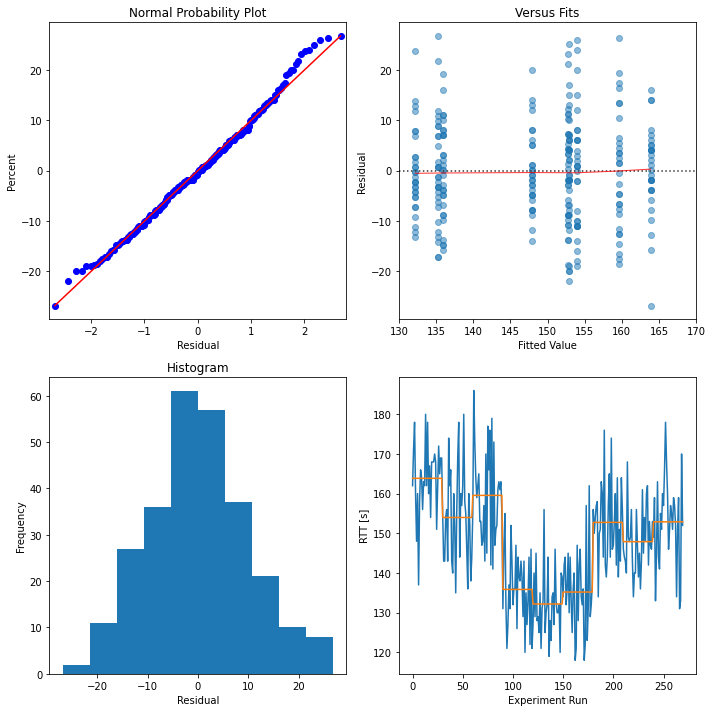

In [19]:
residuals = model_rtt.resid
fitted_y = model_rtt.fittedvalues

fig, axs = plt.subplots(2,2, figsize=(10,10))

# Q-Q plot
graph1 = sm.qqplot(residuals, line='s', xlabel="Residual", ylabel="Percent",ax=axs[0,0])
axs[0,0].set_title("Normal Probability Plot")

# Histogram
axs[1,0].hist(residuals)
axs[1,0].set_ylabel("Frequency")
axs[1,0].set_xlabel("Residual")
axs[1,0].set_title("Histogram")

# Actual Vs. Predicted
sns.residplot(fitted_y, residuals, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axs[0,1])
axs[0,1].set_xlim([130,170])
axs[0,1].set_title("Versus Fits")
axs[0,1].set_ylabel("Residual")
axs[0,1].set_xlabel("Fitted Value")

# Runs Vs. Fitted
axs[1,1].plot(df['RTT'], label="Actual RTT")
axs[1,1].plot(fitted_y, label="Predicted RTT")
axs[1,1].set_xlabel("Experiment Run")
axs[1,1].set_ylabel("RTT [s]")


plt.tight_layout()

Q-Q plots are used to find the type of distribution for a random variable. You can tell the type of distribution using the power of the Q-Q plot just by looking at the plot. From the abova Q-Q plot, we can conclude the residuals of the ANOVA test are indeed normally distributed. This is further supported by the histogram plot.

## Two-way ANOVA test of RTT
Use a two-way ANOVA test to see if the means between groups are statistically different. This is achieved by reviewing the p-value in the ANOVA results; p-values < 0.05 are statistically significant. First, we'll examine the interaction between the factors.

Text(0, 0.5, '')

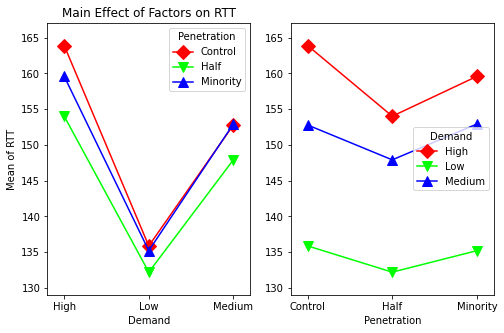

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(8,5))

fig = interaction_plot(df['Demand'], df['Penetration'], df['RTT'], ms=10, ax=axs[0], markers=['D',"v",'^'])
axs[0].set_title("Main Effect of Factors on RTT")
axs[0].set_ylabel("Mean of RTT")

fig = interaction_plot(df['Penetration'], df['Demand'], df['RTT'], ms=10, ax=axs[1], markers=['D',"v",'^'])
axs[1].set_ylabel("")

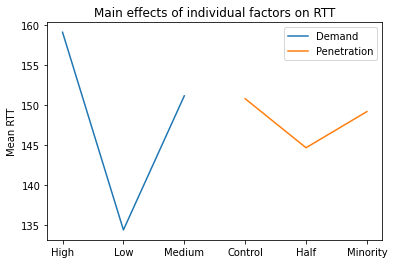

In [21]:
mean_demand = df.groupby(['Demand'])['RTT'].mean()
mean_penetration = df.groupby(['Penetration'])['RTT'].mean()

plt.figure(figsize=(6,4))
plt.title("Main effects of individual factors on RTT")
plt.plot(mean_demand, label="Demand")
plt.plot(mean_penetration, label="Penetration")
plt.ylabel("Mean RTT")
plt.legend()

In [22]:
model_rtt = ols('RTT ~ Demand + Penetration + Demand:Penetration', data=df).fit()
sm.stats.anova_lm(model_rtt, typ=2)

,sum_sq,df,F,PR(>F)
Demand,28668.007407,2.0,138.210537,1.162837e-41
Penetration,1819.918519,2.0,8.773959,2.051857e-04
Demand:Penetration,364.281481,4.0,0.878114,4.775200e-01
Residual,27068.666667,261.0,NaN,NaN


From the above table, we observe that the interaction between the factors is insignificant with a p-value (0.477) > 0.05. Moreover, the individual factors can explain a significant amount of variation in average RTT (p-values < 0.05).

ANOVA tells us which parameters are significant, but not which levels are actually different from one another. To test this, we use a post-hoc test.

When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey’s HSD test).

## Post Hoc Tests of RTT

ANOVA will tell you which parameters are significant, but not which levels are actually different from one another. To test this we can use a post-hoc test. The pairwise test lets us see which groups are different from one another.

In [28]:
model_rtt_2 = ols("RTT ~ C(Demand) + C(Penetration)", df).fit()
pair_t = model_rtt_2.t_test_pairwise('C(Penetration)')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Half-Control,-6.133333,1.516726,-4.043799,0.000069,-9.119700,-3.146967,0.000207,True
Minority-Control,-1.611111,1.516726,-1.062230,0.289098,-4.597478,1.375255,0.289098,False
Minority-Half,4.522222,1.516726,2.981569,0.003135,1.535856,7.508589,0.006259,True


This output shows the pairwise differences between the three penetration rate levels. The results shows that there are significant differences (p-value < 0.05) between
- *Control* and *half* levels
- *Minority* and *half* levels

but no difference between penetration levels *control* and *minority*.

In [29]:
pair_t = model_rtt_2.t_test_pairwise('C(Demand)')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Low-High,-24.722222,1.516726,-16.299732,7.553405e-42,-27.708589,-21.735856,0.000000e+00,True
Medium-High,-7.955556,1.516726,-5.245217,3.196919e-07,-10.941922,-4.969189,3.196919e-07,True
Medium-Low,16.766667,1.516726,11.054515,1.303710e-23,13.780300,19.753033,0.000000e+00,True


This output shows the pairwise differences between the three demand levels. The results shows that there are significant differences (p-value < 0.05) between all levels.

## Conclusion

We found a stastically-significant difference in average RTT by both connected vehicle penetration rates ($f(2)=8.7, p<0.05$) and traffic demand ($f(2)=138.2, p<0.05$), though the interaction between these factors was not significant.

The post-hoc test revealed significant pairwise differences between penetration levels *control* and *minority*, between penetration levels *control* and *half*, and between all levels of demands.